[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/pymc_sdss_2024/blob/master/notebooks/Section1-Bayes_Intro.ipynb)

# An Introduction to Bayesian Statistical Analysis

The process of conducting Bayesian inference can be broken down into three general steps (Gelman *et al.* 2013):

![](https://github.com/fonnesbeck/probabilistic_programming_pymc/blob/main/notebooks/images/123.png?raw=true)

### Step 1: Specify a probability model

As was noted above, Bayesian statistics involves using probability models to solve problems. So, the first task is to *completely specify* the model in terms of probability distributions. This includes everything: unknown parameters, data, covariates, missing data, predictions. All must be assigned some probability density.

This step involves making choices.

- what is the form of the sampling distribution of the data?
- what form best describes our uncertainty in the unknown parameters?

### Step 2: Calculate a posterior distribution

The mathematical form $p(\theta | y)$ that we associated with the Bayesian approach is referred to as a **posterior distribution**.

> posterior /pos·ter·i·or/ (pos-tēr´e-er) later in time; subsequent.

Why posterior? Because it tells us what we know about the unknown $\theta$ *after* having observed $y$.

This posterior distribution is formulated as a function of the probability model that was specified in Step 1. Usually, we can write it down but we cannot calculate it analytically. In fact, the difficulty inherent in calculating the posterior distribution for most models of interest is perhaps the major contributing factor for the lack of widespread adoption of Bayesian methods for data analysis. Various strategies for doing so comprise this tutorial.

**But**, once the posterior distribution is calculated, you get a lot for free:

- point estimates
- credible intervals
- quantiles
- predictions

### Step 3: Check your model

Though frequently ignored in practice, it is critical that the model and its outputs be assessed before using the outputs for inference. Models are specified based on assumptions that are largely unverifiable, so the least we can do is examine the output in detail, relative to the specified model and the data that were used to fit the model.

Specifically, we must ask:

- does the model fit data?
- are the conclusions reasonable?
- are the outputs sensitive to changes in model structure?


## Example: binomial calculation

Binomial model is suitable for data that are generated from a sequence of exchangeable Bernoulli trials. These data can be summarized by $y$, the number of times the event of interest occurs, and $n$, the total number of trials. The model parameter is the expected proportion of trials that an event occurs.

$$p(Y|\theta) = \frac{n!}{y! (n-y)!} \theta^{y} (1-\theta)^{n-y}$$

where $y \in \{0, 1, \ldots, n\}$ and $p \in [0, 1]$.

To perform Bayesian inference, we require the specification of a prior distribution. A reasonable choice is a uniform prior on [0,1] which has two implications:

1. makes all probability values equally probable *a priori* 
2. makes calculation of the posterior easy

The second task in performing Bayesian inference is, given a fully-specified model, to calculate a posterior distribution. As we have specified the model, we can calculate a posterior distribution up to a proportionality constant (that is, a probability distribution that is **unnormalized**):

$$P(\theta | n, y) \propto P(y | n, \theta) P(\theta) = \theta^y (1-\theta)^{n-y}$$

We can present *different posterior distributions* as a function of *different realized data*.

We can also calculate posterior estimates for $\theta$ by *maximizing* the unnormalized posterior using optimization. 

For example, let's plot this unnormalized posterior for data comprising of 3 observed events from 5 trials:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

p_range = np.linspace(0, 1, num=100, endpoint=False)

def binomial_posterior(n, y):
    plt.plot(p_range, (p_range**y) * (1 - p_range)**(n-y))
    plt.xlabel('p');

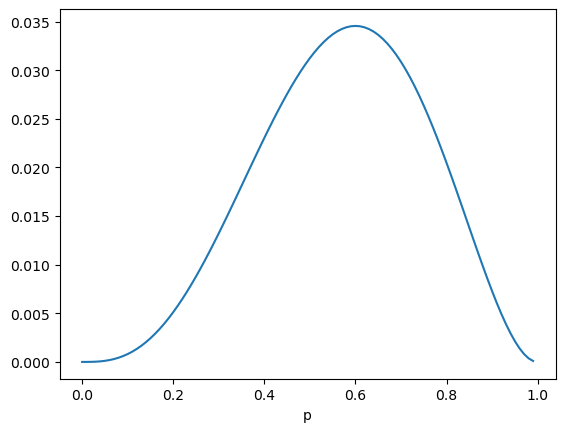

In [2]:
binomial_posterior(n=5, y=3)

What we see here is a function that characterizes the relatve evidence for different values of $p$, conditional on the assumed binomial model (with a uniform prior) and the observed data. Since the data are small, there is still reasonable support across the (0,1) range.

Let's increase the sample size to 12 events from 20 trials:

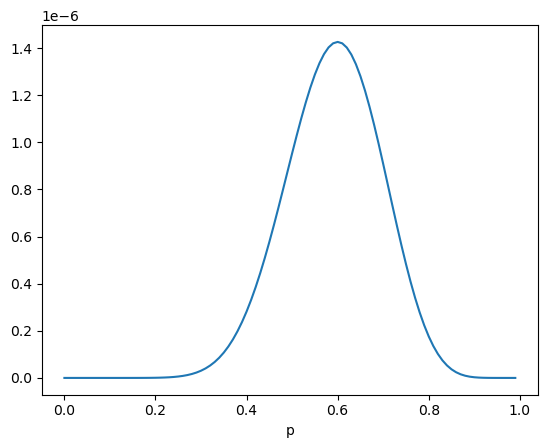

In [3]:
binomial_posterior(n=20, y=12)

And again to 750 observations. Note that for this contrived example, the proportion of observed events is the same across sample sizes.

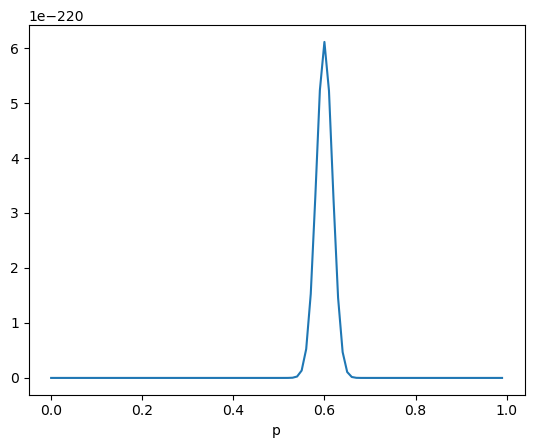

In [4]:
binomial_posterior(n=750, y=450)

So as the sample size gets large, the posterior narrows, representing the reduction in residual uncertainty. Notice also that the posterior distributions start to look more and more Gaussian!

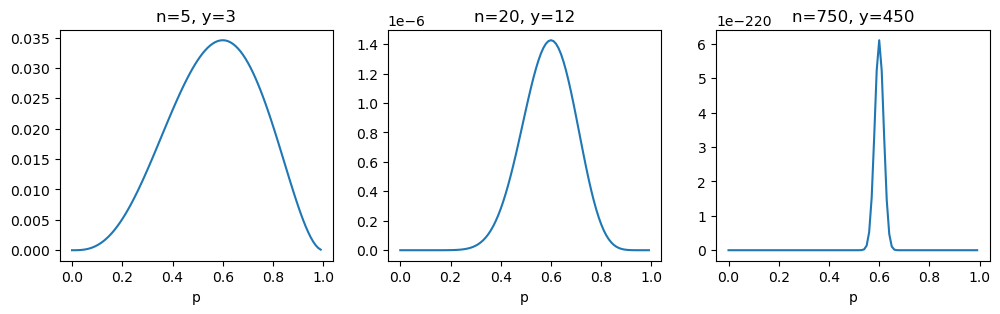

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, (n, y) in zip(axes, [(5, 3), (20, 12), (750, 450)]):
    ax.plot(p_range, (p_range**y) * (1 - p_range)**(n-y))
    ax.set_xlabel('p')
    ax.set_title(f'n={n}, y={y}')

## Informative Priors

Formally, we justify a non-informative prior by the **Principle of Insufficient Reason**, which states that uniform probability is justified when there is nothing known about the parameter in question. Frequently, it is inappropriate to employ an uninformative prior as we have done above. For some distributions there is no clear choice of such a prior, particularly when parameters are transformed. For example, a flat prior on the real line is not flat on the unit interval. 

There are two alternative interpretations of the prior distribution.

1. **Population prior**: a distribution that represents a notional population of values for the parameter, from which those in the current experiment/study have been drawn.
2. **Knowledge prior**: a distribution that represents our uncertainty about the true value of the parameter.

In either case, a prior distribution should include in its support all parameter values that are plausible.

Choosing an informative prior presents an analytic challenge with respect to the functional form of the prior distribution. We would like a prior that results in a posterior distribution that is simple to work with. Taking our binomial likelihood again as an example:

$$P(\theta | n, y) \propto \theta^y (1-\theta)^{n-y}$$

we can see that it is of the general form $\theta^a (1-\theta)^b$. Thus, we are looking for a parametric distribution that describes the distribution of or uncertainty in $\theta$ that is of this general form. The **beta distribution** satisfies these criteria:

$$P(\theta | \alpha, \beta) \propto \theta^{\alpha-1} (1-\theta)^{\beta-1}$$

The parameters $\alpha, \beta$ are called **hyperparameters**, and here they suggest prior information corresponding to $\alpha-1$ "successes" and $\beta-1$ failures. 

Let's go ahead and calculate the posterior distribution:

$$\begin{aligned}
P(\theta | n, y) &\propto& \theta^y (1-\theta)^{n-y} \theta^{\alpha-1} (1-\theta)^{\beta-1} \\
    &=& \theta^{y+\alpha-1} (1-\theta)^{n-y+\beta-1} \\
    &=& \text{Beta}(\alpha + y, \beta + n -y) \\
\end{aligned}$$

So, in this instance, the posterior distribution follows the same functional form as the prior. This phenomenon is referred to as **conjugacy**, whereby the beta distribution is in the conjugate family for the binomial sampling distribution.

> What is the posterior distribution when a Beta(1,1) prior is used?

Formally, we defined conjugacy by saying that a class $\mathcal{P}$ is a conjugate prior for the class $\mathcal{F}$ of likelihoods if:

$$P(\theta | y) \propto f(y|\theta) p(\theta) \in \mathcal{P} \text{ for all } f \in \mathcal{F} \text{ and } p \in \mathcal{P}$$

This definition is quite vague for practical application, so we are more interested in **natural** conjugates, whereby the conjugacy is specific to a particular distribution, and not just a class of distributions.

In the case of the binomial model with a beta prior, we can now analytically calculate the posterior mean and variance for the model:

$$E[\theta|n,y] = \frac{\alpha + y}{\alpha + \beta + n}$$

$$\begin{aligned}
\text{Var}[\theta|n,y] &=& \frac{(\alpha + y)(\beta + n - y)}{(\alpha + \beta + n)^2(\alpha + \beta + n +1)} \\
&=& \frac{E[\theta|n,y] (1-E[\theta|n,y])}{\alpha + \beta + n +1}
\end{aligned}$$

Notice that the posterior expectation will always fall between the sample and prior means.

Notice also what happens when $y$ and $n-y$ get large.

### Exercise: probability of female birth given placenta previa

Placenta previa is an unusual condition of pregnancy in which the placenta is implanted low in the uterus, complicating a normal delivery. An German study of the sex of placenta previa births found that of 980 births, 437 were female. 

How much evidence does this provide for the claim that the proportion of female births in the population of placenta previa births $\theta$ is less than 0.485 (this is the proportion of female births in the general population)?

1. Calculate the the posterior distribution for $\theta$ using a uniform prior, and plot the prior, likelihood and posterior on the same axes.

2. Find a prior distribution that has a mean of 0.485 and prior "sample size" of 100. Plot the prior, likelihood and posterior on the same axes.

**Hint:** Use the `scipy.stats` module to generate a beta and binomial distributions, with the `pdf` and `pmf` functions, respectively.

In [6]:
# Write your answer here

# Evaluating Hypotheses with Bayes

Statistical inference is a process of learning from incomplete or imperfect (error-contaminated) data. Can account for this "imperfection" using either a sampling model or a measurement error model.

### Statistical hypothesis testing

The *de facto* standard for statistical inference is statistical hypothesis testing. The goal of hypothesis testing is to evaluate a **null hypothesis**. There are two possible outcomes:

- reject the null hypothesis
- fail to reject the null hypothesis

*Rejection* occurs when a chosen test statistic is higher than some pre-specified threshold valuel; *non-rejection* occurs otherwise.

Notice that neither outcome says anything about the quantity of interest, the **research hypothesis**. 

Setting up a statistical test involves several subjective choices by the user that are rarely justified based on the problem or decision at hand:

- statistical test to use
- null hypothesis to test
- significance level

Choices are often based on arbitrary criteria, including "statistical tradition" (Johnson 1999). The resulting evidence is indirect, incomplete, and typically overstates the evidence against the null hypothesis (Goodman 1999).

Most importantly to applied users, the results of statistical hypothesis tests are very easy to misinterpret. 

### Estimation 

Instead of testing, a more informative and effective approach for inference is based on **estimation** (be it frequentist or Bayesian). That is, rather than testing whether two groups are different, we instead pursue an estimate of *how different* they are, which is fundamentally more informative. 

Additionally, we include an estimate of **uncertainty** associated with that difference which includes uncertainty due to our lack of knowledge of the model parameters (*epistemic uncertainty*) and uncertainty due to the inherent stochasticity of the system (*aleatoric uncertainty*).

## One Group

Before we compare two groups using Bayesian analysis, let's start with an even simpler scenario: statistical inference for one group.

For this we will use Gelman et al.'s (2007) radon dataset. In this dataset the amount of the radioactive gas radon has been measured among different households in all counties of several states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to be more strongly present in households containing a basement and to differ in amount present among types of soil.

>  the US EPA has set an action level of 4 pCi/L. At or above this level of radon, the EPA recommends you take corrective measures to reduce your exposure to radon gas.

![radon](images/how_radon_enters.jpg)

Let's import the dataset:

In [7]:
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

In [8]:
import polars as pl

DATA_URL = 'https://raw.githubusercontent.com/fonnesbeck/probabilistic_programming_pymc/master/data/'

try:
    radon = pl.read_csv('../data/radon.csv')
except FileNotFoundError:
    radon = pl.read_csv(DATA_URL + 'radon.csv')
radon.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,windoor,rep,stratum,wave,starttm,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
i64,f64,str,str,f64,i64,f64,f64,f64,f64,str,str,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,i64,f64
0,5081.0,"""MN""","""MN""",27.0,55735,5.0,1.0,1.0,3.0,"""N""",""" """,""" 2""",4.0,""" 41""",930.0,930.0,12088.0,12288.0,2.2,9.7,1146.49919,1.0,0.0,1.0,"""AITKIN""",27001.0,0.502054,0,0.832909
1,5082.0,"""MN""","""MN""",27.0,55748,5.0,1.0,0.0,4.0,"""Y""",""" """,""" 5""",2.0,""" 40""",1615.0,1615.0,11888.0,12088.0,2.2,14.5,471.366223,0.0,0.0,1.0,"""AITKIN""",27001.0,0.502054,0,0.832909
2,5083.0,"""MN""","""MN""",27.0,55748,5.0,1.0,0.0,4.0,"""Y""",""" """,""" 3""",2.0,""" 42""",1030.0,1515.0,20288.0,21188.0,2.9,9.6,433.316718,0.0,0.0,1.0,"""AITKIN""",27001.0,0.502054,0,1.098612
3,5084.0,"""MN""","""MN""",27.0,56469,5.0,1.0,0.0,4.0,"""Y""",""" """,""" 2""",2.0,""" 24""",1410.0,1410.0,122987.0,123187.0,1.0,24.3,461.62367,0.0,0.0,1.0,"""AITKIN""",27001.0,0.502054,0,0.09531
4,5085.0,"""MN""","""MN""",27.0,55011,3.0,1.0,0.0,4.0,"""Y""",""" """,""" 3""",2.0,""" 40""",600.0,600.0,12888.0,13088.0,3.1,13.8,433.316718,0.0,0.0,3.0,"""ANOKA""",27003.0,0.428565,1,1.163151


Let's focus on the (log) radon levels measured in a single county (Hennepin). 

Suppose we are interested in:

- whether the mean log-radon value is greater than 4 pCi/L in Hennepin county
- the probability that any randomly-chosen household in Hennepin county has a reading of greater than 4

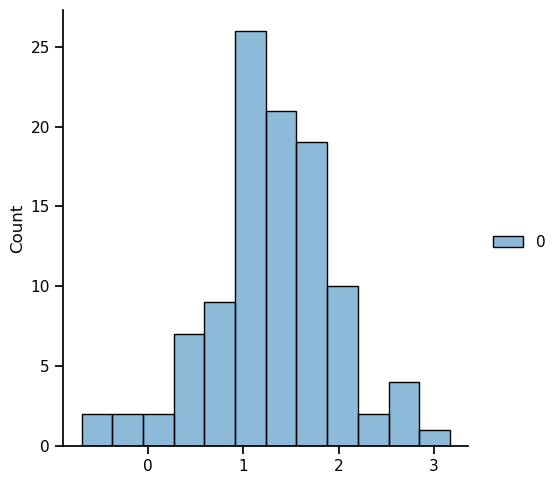

In [9]:
hennepin_radon = radon.filter(pl.col("county") =="HENNEPIN").select("log_radon")
sns.displot(hennepin_radon);

### The model

Recall that the first step in Bayesian inference is specifying a **full probability model** for the problem.

This consists of:

- a likelihood function(s) for the observations
- priors for all unknown quantities

The measurements look approximately normal, so let's start by assuming a normal distribution as the sampling distribution (likelihood) for the data. 

$$y_i \sim N(\mu, \sigma^2)$$

(don't worry, we can evaluate this assumption)

This implies that we have 2 unknowns in the model; the mean and standard deviation of the distribution. 

#### Prior choice

How do we choose distributions to use as priors for these parameters? 

There are several considerations:

- discrete vs continuous values
- the support of the variable
- the available prior information

While there may likely be prior information about the distribution of radon values, we will assume no prior knowledge, and specify a **diffuse** prior for each parameter.

Since the mean can take any real value (since it is on the log scale), we will use another normal distribution here, and specify a large variance to allow the possibility of very large or very small values:

$$\mu \sim N(0, 10^2)$$

For the standard deviation, we know that the true value must be positive (no negative variances!). I will choose a uniform prior bounded from below at zero and from above at a value that is sure to be higher than any plausible value the true standard deviation (on the log scale) could take.

$$\sigma \sim U(0, 10)$$

We can encode these in a Python model, using the PyMC package, as follows:

In [10]:
import pymc as pm

with pm.Model() as radon_model:
    
    mu = pm.Normal('mu', mu=0, sigma=10)
    sigma = pm.Uniform('sigma', 0, 10)

> ## Software
> Today there is an array of software choices for Bayesians, including both open source software (*e.g.*, Stan, PyMC, Pyro, TensorFlow Probability) and commercial (*e.g.*, SAS, Stata). These examples can be replicated in any of these environments.

All that remains is to add the likelihood, which takes $\mu$ and $\sigma$ as parameters, and the log-radon values as the set of observations:

In [11]:
with radon_model:
    
    dist = pm.Normal('dist', mu=mu, sigma=sigma, observed=hennepin_radon)

Before we go ahead and estimate the model paramters from the data, it's a good idea to perform a **prior predictive check**. This involves sampling from the model before data are incorporated, and gives you an idea of the range of observations that would be considered reasonable within the scope of the modeling assumptions (including choice of priors). If the simnulations generate too many extreme observations relative to our expectations based on domain knowledge, then it can be an indication of problems with model formulation.

In [12]:
with radon_model:
    
    prior_sample = pm.sample_prior_predictive(1000)

Sampling: [dist, mu, sigma]


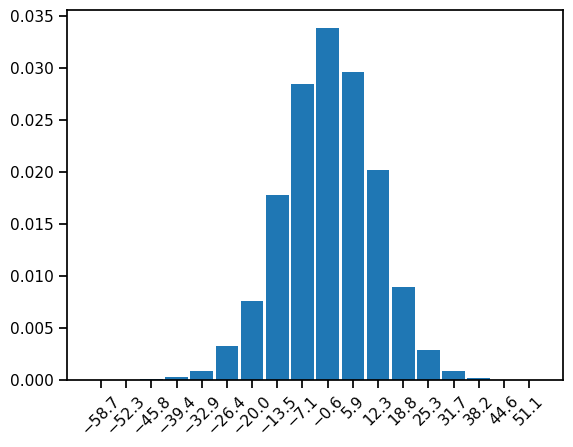

In [13]:
import arviz as az
az.plot_dist(prior_sample.prior_predictive['dist'], kind='hist')
plt.xticks(rotation = 45);

Let's quickly compare this to the data values, especially checking the minimum and maximum values:

In [14]:
radon.select("log_radon").describe()

statistic,log_radon
str,f64
"""count""",919.0
"""null_count""",0.0
"""mean""",1.264779
"""std""",0.819355
"""min""",-2.302585
"""25%""",0.693147
"""50%""",1.308333
"""75%""",1.808289
"""max""",3.877432


Now, we will fit the model using **Markov chain Monte Carlo (MCMC)**, which will be covered in detail in an upcoming section. This will draw samples from the posterior distribution (which cannot be calculated exactly).

In [15]:
with radon_model:
    
    samples = pm.sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Having fit the model, we can look at the posterior estimate of the mean relative to the critical value (on the log scale).

The plot shows the posterior distribution of $\mu$, along with an estimate of the 95% posterior **credible interval**. 

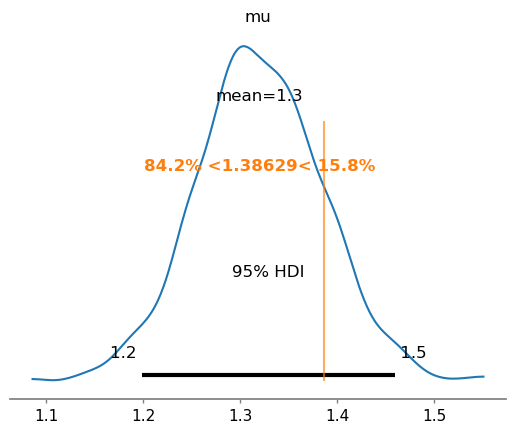

In [16]:
az.plot_posterior(samples, var_names=['mu'], ref_val=np.log(4), hdi_prob=0.95);

The output

    85% < 1.38629 < 15%
    
informs us that the probability of $\mu$ being less than log(4) is 85% and the corresponding probability of being greater than log(4) is 15%.

> The posterior probability that the mean level of household radon in Henneprin County is greater than 4 pCi/L is 0.15.

### Prediction

What is the probability that a given household has a log-radon measurement larger than four? To answer this, we make use of the **posterior predictive distribution**.

$$p(z |y) = \int_{\theta} p(z |\theta) p(\theta | y) d\theta$$

where here $z$ is the predicted value and y is the data used to fit the model.

While PyMC has functions for calculating the posterior predictive distribution, we can readily estimate this from the posterior samples of the parameters in the model. First, extract the values of the mean and standard deviation of the sampling distribution:

In [17]:
posterior_data = az.extract(samples.posterior)

mus = posterior_data['mu'].values
sigmas = posterior_data['sigma'].values

In [18]:
from scipy.stats import norm
np.random.seed(RANDOM_SEED)

radon_samples = norm(loc=mus, scale=sigmas).rvs()

In [19]:
(radon_samples > np.log(4)).mean()

0.4605

> The posterior probability that a randomly-selected household in Henneprin County contains radon levels in excess of 4 pCi/L is about 0.46.

### Model checking

But, ***how do we know this model is any good?***

Its important to check the fit of the model, to see if its assumptions are reasonable. One way to do this is to perform **posterior predictive checks**. This involves generating simulated data using the model that you built, and comparing that data to the observed data.

One can choose a particular statistic to compare, such as tail probabilities or quartiles, but here it is useful to compare them graphically.

We already have these simulations from the previous exercise!

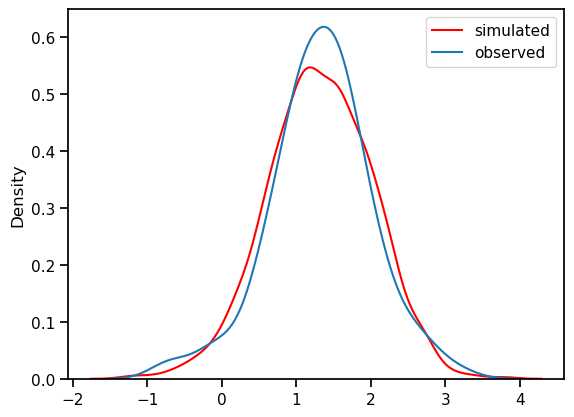

In [20]:
ax = sns.kdeplot(radon_samples, label='simulated', color='red')
sns.kdeplot(hennepin_radon, label='observed', ax=ax, color='blue')
plt.legend();

### Exercise: Prior sensitivity

Its important to check the sensitivity of your choice of priors to the resulting inference. Specify the radon model using different priors for the mean and stanard deviation. [For reference, here is a link to the probability distributions API for PyMC](https://docs.pymc.io/api/distributions.html), which lists the available distributions.

Think hard about the desirable properties of priors for each variable.

In [ ]:
with pm.Model() as prior_sensitivity:
    
    mu = my_mu_prior
    sigma = my_sigma_prior
    
    dist = pm.Normal('dist', mu=mu, sigma=sigma, observed=hennepin_radon)
    
    sensitivity_samples = pm.sample(1000, tune=1000)

In [ ]:
az.plot_posterior(sensitivity_samples, var_names=['mu'], ref_val=np.log(4));

Here is the original model for comparison:

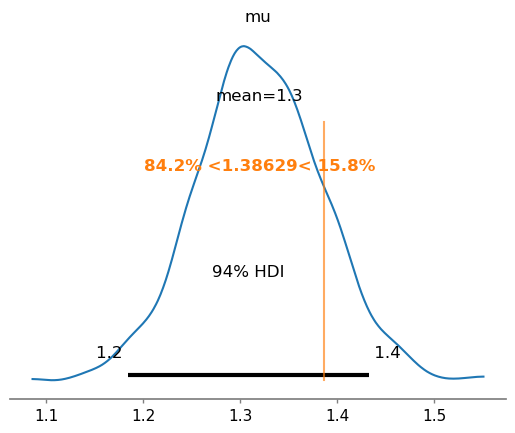

In [28]:
az.plot_posterior(samples, var_names=['mu'], ref_val=np.log(4));

## Two Groups with Continuous Outcome

Let's move on to a slightly different problem: rather than estimating a single group's distribution, what if we have data from two unknown distributions and we want to estimate how different they are.

We will use a fictitious example from Kruschke (2012) concerning the evaluation of a clinical trial for drug evaluation. The trial aims to evaluate the efficacy of a "smart drug" that is supposed to increase intelligence by comparing IQ scores of individuals in a treatment arm (those receiving the drug) to those in a control arm (those recieving a placebo). There are 47 individuals and 42 individuals in the treatment and control arms, respectively.

In [23]:
drug = pl.DataFrame(dict(iq=(101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101),
                         group='drug'))
placebo = pl.DataFrame(dict(iq=(99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99),
                            group='placebo'))

trial_data = pl.concat([drug, placebo])
trial_data.plot.hist('iq', by='group')

:NdOverlay   [group]
   :Histogram   [iq]   (iq_count)

Since there appear to be extreme ("outlier") values in the data, we will choose a Student-t distribution to describe the distributions of the scores in each group. This sampling distribution adds **robustness** to the analysis, as a T distribution is less sensitive to outlier observations, relative to a normal distribution. 

The three-parameter Student-t distribution allows for the specification of a mean $\mu$, a precision (inverse-variance) $\lambda$ and a degrees-of-freedom parameter $\nu$:

$$f(x|\mu,\lambda,\nu) = \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\frac{\nu}{2})} \left(\frac{\lambda}{\pi\nu}\right)^{\frac{1}{2}} \left[1+\frac{\lambda(x-\mu)^2}{\nu}\right]^{-\frac{\nu+1}{2}}$$
           
the degrees-of-freedom parameter essentially specifies the "normality" of the data, since larger values of $\nu$ make the distribution converge to a normal distribution, while small values (close to zero) result in heavier tails.

Thus, the likelihood functions of our model are specified as follows:

$$\begin{align}
y^{(drug)}_i &\sim T(\nu, \mu_1, \sigma_1) \\
y^{(placebo)}_i &\sim T(\nu, \mu_2, \sigma_2)
\end{align}$$

As a simplifying assumption, we will assume that the degree of normality $\nu$ is the same for both groups. 

### Prior choice

Since the means are real-valued, we will apply normal priors. Since we know something about the population distribution of IQ values, we will center the priors at 100, and use a standard deviation that is more than wide enough to account for plausible deviations from this population mean:

$$\mu_k \sim N(100, 10^2)$$

In [24]:
with pm.Model() as drug_model:
    
    mu_0 = pm.Normal('mu_0', 100, sigma=10)
    mu_1 = pm.Normal('mu_1', 100, sigma=10)

Similarly, we will use a uniform prior for the standard deviations, with an upper bound of 20.

In [25]:
with drug_model:
    sigma_0 = pm.Uniform('sigma_0', lower=0, upper=20)
    sigma_1 = pm.Uniform('sigma_1', lower=0, upper=20)

For the degrees-of-freedom parameter $\nu$, we will use an **exponential** distribution with a mean of 30; this allocates high prior probability over the regions of the parameter that describe the range from normal to heavy-tailed data under the Student-T distribution.

In [26]:
with drug_model:
    nu = pm.Exponential('nu_minus_one', 1/30) 


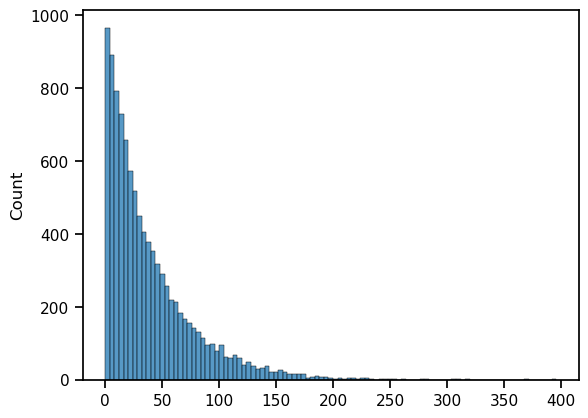

In [27]:
sns.histplot(pm.draw(pm.Exponential.dist(1/39), 10_000));

In [30]:
with drug_model:

    placebo_like = pm.StudentT('placebo_like', nu=nu, mu=mu_0, sigma=sigma_0, observed=placebo["iq"])
    drug_like = pm.StudentT('drug_like', nu=nu, mu=mu_1, sigma=sigma_1, observed=drug["iq"])
    

Now that the model is fully specified, we can turn our attention to tracking the posterior quantities of interest. Namely, we can calculate the difference in means between the drug and placebo groups.

As a joint measure of the groups, we will also estimate the "effect size", which is the difference in means scaled by the pooled estimates of standard deviation. This quantity can be harder to interpret, since it is no longer in the same units as our data, but it is a function of all four estimated parameters.

In [31]:
with drug_model:
    
    diff_of_means = pm.Deterministic('difference of means', mu_1 - mu_0)
    
    effect_size = pm.Deterministic('effect size', 
                        diff_of_means / np.sqrt((sigma_1**2 + sigma_0**2) / 2))



In [32]:
with drug_model:
    
    drug_trace = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, mu_1, sigma_0, sigma_1, nu_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


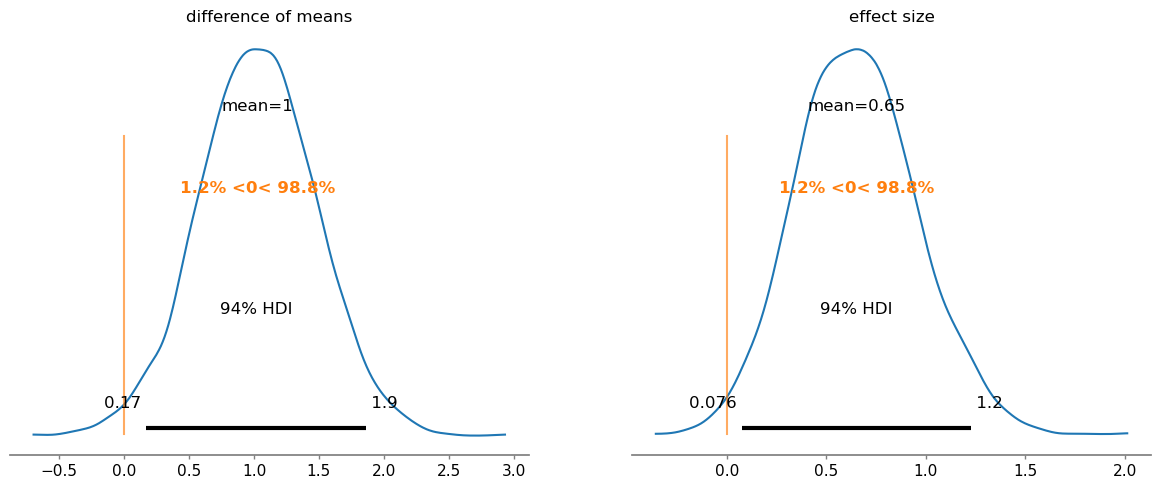

In [33]:
az.plot_posterior(drug_trace, 
          var_names=['difference of means', 'effect size'],
          ref_val=0);

> The posterior probability that the mean IQ of subjects in the treatment group is greater than that of the control group is approximately 0.99.

### Exercise: Likelihood sensitivity

Was it really helpful to use a Student-T distribution for the likelihood? Try fitting the model with a normal likelihood and compare the results.

In [ ]:
# Write your answer here

---

# References

Gelman, Andrew, John B. Carlin, Hal S. Stern, David B. Dunson, Aki Vehtari, and Donald B. Rubin. 2013. Bayesian Data Analysis, Third Edition. CRC Press.

Pilon, Cam-Davidson. [Probabilistic Programming and Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)